In [1]:
import numpyro
numpyro.enable_x64()
# numpyro.set_platform('gpu')

import jax
print(jax.devices())

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value, init_to_sample, Trace_ELBO, TraceGraph_ELBO

from numpyro.infer.svi import SVI
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoLaplaceApproximation, AutoDAIS, AutoBNAFNormal, AutoIAFNormal, AutoMultivariateNormal
from numpyro.optim import Adam, ClippedAdam

import tensorflow_probability.substrates.jax as tfp

from jax import numpy as jnp
from jax import random, vmap

import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns

import siuba as s
from siuba import _

from plotnine import *

from matplotlib import pyplot as plt

import pickle

from lib.helpers import *
from lib.models import *
from lib.simdata import *

[GpuDevice(id=0, process_index=0)]


In [2]:
## Define functions

def fit_svi(model, x_data, y_data, optimizer=Adam(1e-3), loss=TraceGraph_ELBO(), n_steps=10_000, full_rank = False, filename=None, **kwargs):
    if full_rank:
        guide = AutoMultivariateNormal(model, **kwargs)
    else:
        guide = AutoNormal(model, **kwargs)

    if filename is not None and os.path.exists(filename):
        result = pickle.load(open(filename, "rb"))
        return result
    else:
        svi = SVI(model, guide, optimizer, loss)
        result = svi.run(random.PRNGKey(1), n_steps, x_data, y_data)
        output = {"params": result.params, "guide": guide, "losses": result.losses}

        if filename is not None:
            pickle.dump(output, open(filename, "wb"))

        return(output)


def arviz_from_svi(model, guide, params, *args, obs_data=None, num_samples = 1_000):
    
    posterior_samples = guide.sample_posterior(random.PRNGKey(1), params=params, sample_shape=(num_samples,))
    samples_posterior_predictive = Predictive(model=model, posterior_samples=posterior_samples)(random.PRNGKey(1), *args)
    samples_prior_predictive = Predictive(model=model, params=None, num_samples=num_samples)(random.PRNGKey(2), *args)

    return az.from_dict(
        {k: np.expand_dims(v, 0) for k, v in posterior_samples.items()},
        prior = {k: np.expand_dims(v, 0) for k, v in samples_prior_predictive.items()},
        posterior_predictive = {k: np.expand_dims(v, 0) for k, v in samples_posterior_predictive.items()},
        observed_data = {"yhat": obs_data}
    )


def apply_rounding(df, mixing_probs = [.1, .4, .5]):
    output = (df >>
    s.mutate(rnd_policy = np.random.choice([0,1,2], size = len(df), p = mixing_probs)) >>
    s.mutate(estimate = s.if_else(
        _.rnd_policy==0, np.round(np.random.beta(1,1, len(df))*20.),
        s.if_else(_.rnd_policy==1, np.round(_.estimate*20.), np.round(_.estimate*10.)*2.)
    ))
    )
    output["estimate"] = output["estimate"].astype("int")
    
    return(output)


def plot_param_recovery(posterior, params, param_name, var_name):
#     x = (
#     posterior >>
#     s.mutate(d_base = _.d_base_pop + _.d_base_r * _.d_base_sd, 
#              d_prime = _.d_base + np.exp(_.d_delta_pop + _.d_delta_r *  _.d_delta_sd)
# #              d_prime = _.d_base + np.exp(_.d_delta_pop + _.d_delta_r *  _.d_delta_sd)
#          ) 
#     )
    x = posterior

    x["param"] = x[param_name]
    x = (
        x >>
        s.group_by("ID") >>
        s.summarize(
        m_base = _.param.mean(),
        ll_base = _.param.quantile(.025),
        ul_base = _.param.quantile(.975),
        )
    )
    
    subj_params = (
        pd.DataFrame(params).reset_index() >> 
        s.rename(ID = _.index)
    )

    plt = (
        pd.merge(x, subj_params, on = "ID") >> 
        # s.mutate(ok = s.if_else(_.ll_base < _.d_base, s.if_else(_.ul_base > _.d_base, 1, 0), 0)) >>
        ggplot(aes(x=var_name, y = "m_base", ymin="ll_base", ymax="ul_base")) + 
        geom_pointrange() +
        geom_abline(intercept=0, slope=1, linetype="dashed") +
        # coord_flip() +
        theme(aspect_ratio=1)
    )

    return(plt)


In [3]:
def np_softplus(x):
    return(np.log(1 + np.exp(x)))

## Load Experiment 1 data
n_participants, n_blocks, n_conditions = 50, 3, 2 # 30, 6, 3 --> led to accurate paramter recovery see "...-backup.p" files

np.random.seed(32325) ## old school but works here

params_bs = {
    "N_prime": {k: 1 + np_softplus(np.random.normal(10, 10)) for k in range(0,n_participants)},
    "N_delta": {k: np_softplus(np.random.normal(5, 5)) for k in range(0,n_participants)},
    "beta": {k: np.random.beta(3,3)*3 for k in range(0, n_participants)},
}

params_bs["N_true"] = {k: params_bs["N_prime"][k] + params_bs["N_delta"][k] for k in range(0,n_participants)}

df = make_sim_data_bs_trials(n_participants, n_blocks, n_conditions, params_bs)

df_bs = apply_rounding(df, [.1, .4, .5])


X_bs, y_bs = make_model_data(df_bs)
print(len(y_bs), "observations")


6000 observations


<AxesSubplot:>

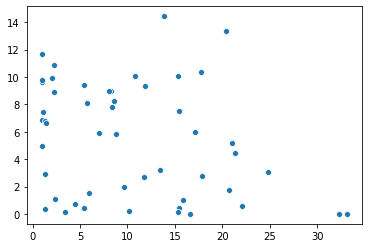

In [4]:
# sns.distplot(list(params_bs["N_delta"].values()))
sns.scatterplot(np.array(list(params_bs["N_prime"].values())), np.array(list(params_bs["N_delta"].values())))

<AxesSubplot:xlabel='estimate'>

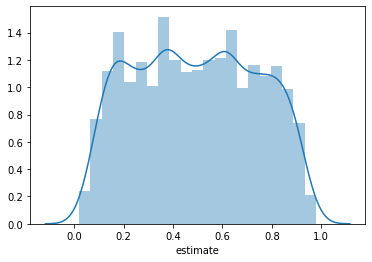

In [5]:
sns.distplot(df.estimate)

In [6]:
## sim PTN data
def make_ks(n_participants):
    ks = np_softplus(np.random.normal(15, 3, size = n_participants))
    
    return {k: 1 + np.round(ks[k]).astype("int") for k in range(0,n_participants)}


n_participants, n_blocks, n_conditions = 50, 3, 2 # 30, 6, 3 --> led to accurate paramter recovery

np.random.seed(323256) ## old school but works here

params = {
    "d_lin": {k: np.random.normal(-.5, .5) for k in range(0,n_participants)},
    "d_delta_lin": {k: np.random.normal(0, .5) for k in range(0,n_participants)},
#     "k": {k: 12. for k in range(0,n_participants)}
    "k": make_ks(n_participants)
}

params["d_base"] = {k: scipy.special.expit(params["d_lin"][k])/2. for k in range(0,n_participants)}

params["d_prime"] = {k: scipy.special.expit(params["d_lin"][k] + np_softplus(params["d_delta_lin"][k]))/2. for k in range(0,n_participants)}
params["d_delta"] = {k: params["d_prime"][k] - params["d_base"][k] for k in range(0,n_participants)}

params_ptn = params

df = make_sim_data_ptn_trials(n_participants, n_blocks, n_conditions, params_ptn, simple_prob=True)

df_ptn = apply_rounding(df, [.1, .4, .5])



X_ptn, y_ptn = make_model_data(df_ptn)
print(len(y_ptn), "observations")

6000 observations


<AxesSubplot:xlabel='estimate'>

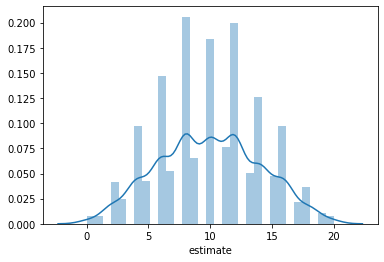

In [7]:
# sns.distplot(list(params_ptn["d_prime"].values()))
# sns.scatterplot(list(params_ptn["d_base"].values()) , list(params_ptn["d_prime"].values()))
sns.distplot(df_ptn.estimate)

## Bayesian Sampler

In [13]:
res_bs = fit_svi(
    bs_complex_mlm_trial_level, 
    X_bs, 
    y_bs,
    optimizer = Adam(1e-3), # ClippedAdam(5e-4, b1=.95),
    loss = TraceGraph_ELBO(num_particles=1),
    n_steps = 10_000,
    full_rank=True,
    filename="local/svi-bs_complex_mlm_trial_level-sim.p"
)

100%|██████████| 10000/10000 [25:23<00:00,  6.56it/s, init loss: 20144.7093, avg. loss [9501-10000]: 13004.7690]


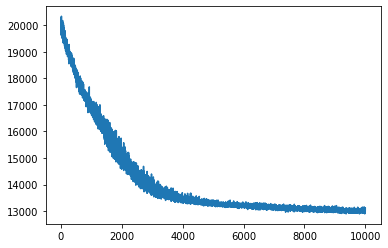

In [17]:
from matplotlib import pyplot as plt
plt.plot(res_bs["losses"])

In [18]:
az_bs = arviz_from_svi(bs_complex_mlm_trial_level, res_bs["guide"], res_bs["params"], X_bs, obs_data=y_bs)

<AxesSubplot:xlabel='yhat / yhat'>

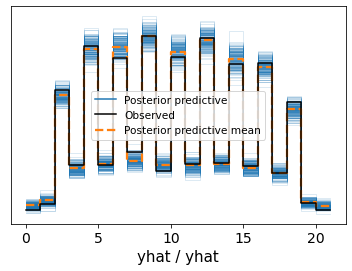

In [19]:
az.plot_ppc(az_bs, num_pp_samples=200)

In [20]:
# this is good
az_bs.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.11271744, 0.40200362, 0.48527894]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

In [21]:
posterior_bs = posterior_to_df_mlm(
    az_bs, 
    ["N_prime_pop","N_delta_pop","N_prime_sd","N_delta_sd", "beta_pop", "beta_sd"],
    ["N_prime_r", "N_delta_r", "N_subj", "N_prime_subj", "beta_subj"]
)

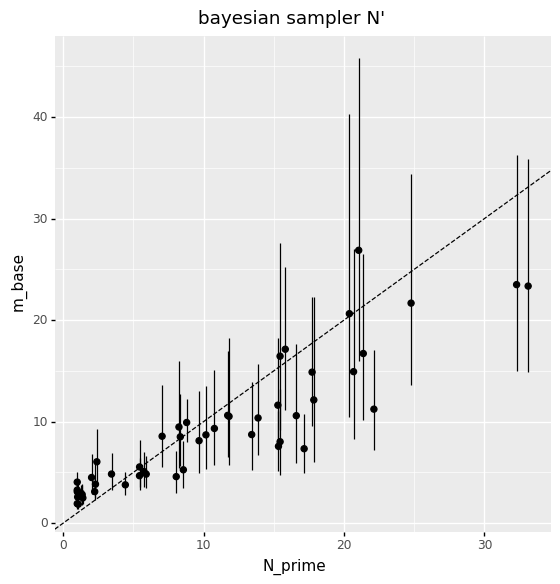

<ggplot: (2955587056027)>

In [22]:
# this looks good now! changing back to exponentiation helped
plot_param_recovery(posterior_bs, params_bs, "N_prime_subj", "N_prime") + labs(title="bayesian sampler N' ")

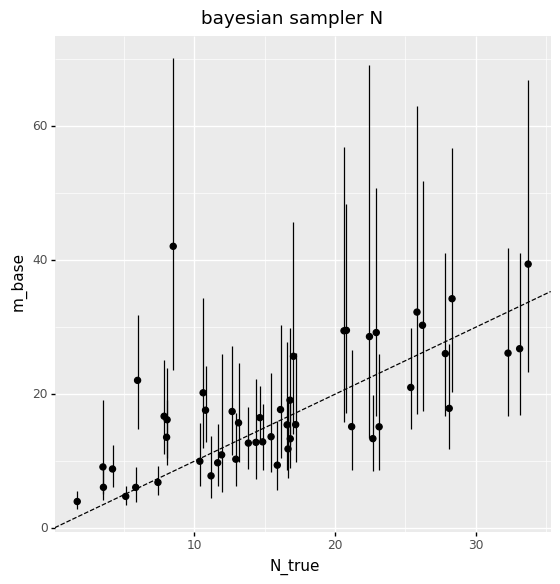

<ggplot: (2955596825755)>

In [23]:
## this looks good
params = params_bs
params["N_true"] = {k: params["N_prime"][k] + params["N_delta"][k] for k in range(0,n_participants)}
plot_param_recovery(posterior_bs, params, "N_subj", "N_true") + labs(title="bayesian sampler N ")

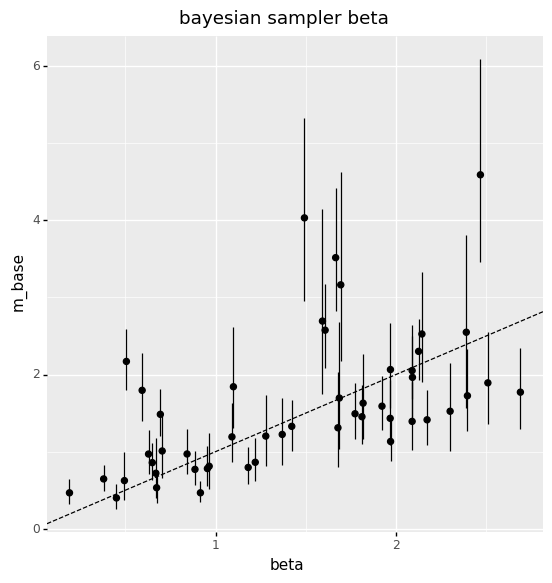

<ggplot: (2955528739490)>

In [24]:
# this looks decent, might be better to switch to sigmoid but making that lower priority.
plot_param_recovery(posterior_bs, params, "beta_subj", "beta") + labs(title="bayesian sampler beta ")

## PTN

In [8]:
res_ptn = fit_svi(
    ptn_simplecond_mlm_trial_level_disc, 
    X_ptn, 
    y_ptn,
    optimizer = Adam(1e-3),
    n_steps = 10_000,
    full_rank=True,
    filename="local/svi-ptn_simplecond_mlm_trial_level_disc-sim-v2.p"
)

100%|██████████| 10000/10000 [23:45<00:00,  7.02it/s, init loss: 19528.4817, avg. loss [9501-10000]: 14685.9400]


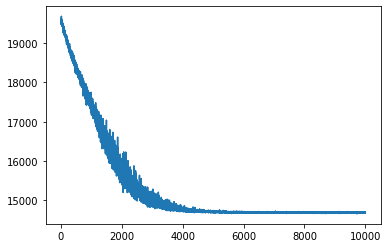

In [9]:
from matplotlib import pyplot as plt
plt.plot(res_ptn["losses"])

In [10]:
az_ptn = arviz_from_svi(bs_complex_mlm_trial_level, res_ptn["guide"], res_ptn["params"], X_ptn, obs_data=y_ptn)

<AxesSubplot:xlabel='yhat / yhat'>

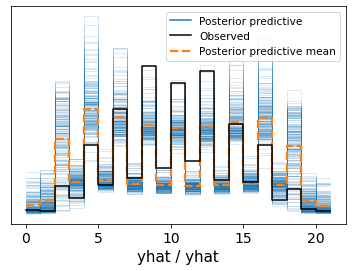

In [11]:
az.plot_ppc(az_ptn, num_pp_samples=200)

In [12]:
az_ptn.posterior.rnd_policy.mean(axis=1)

<xarray.DataArray 'rnd_policy' (chain: 1, rnd_policy_dim_0: 3)>
array([[0.0901631 , 0.42778998, 0.48204691]])
Coordinates:
  * chain             (chain) int64 0
  * rnd_policy_dim_0  (rnd_policy_dim_0) int64 0 1 2

these look good now, seems the problem was the simulation (forgot to use simple conditional probability calculations before).

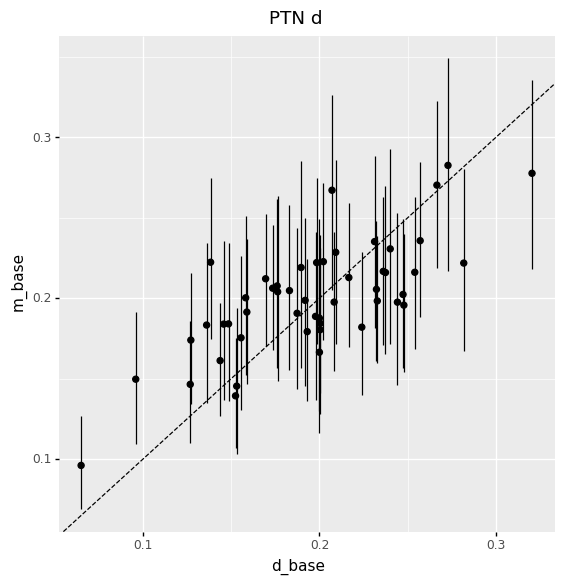

<ggplot: (2934698464239)>

In [14]:
plot_param_recovery(posterior_ptn, params_ptn, "d_subj", "d_base") + labs(title="PTN d ")

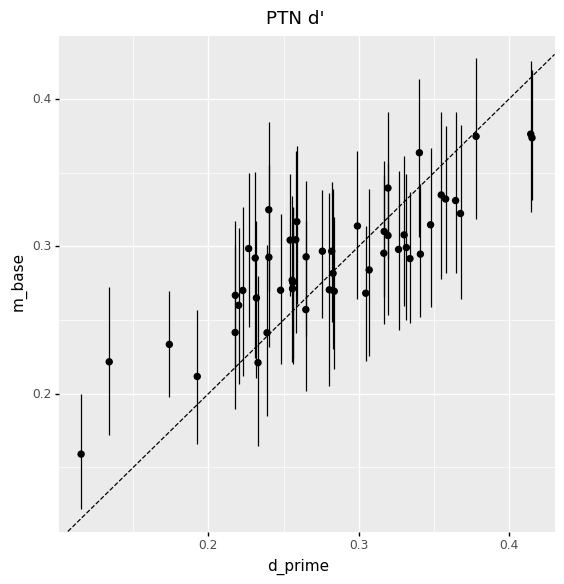

<ggplot: (-9223369102156279622)>

In [15]:
plot_param_recovery(posterior_ptn, params_ptn, "d_prime_subj", "d_prime") + labs(title="PTN d' ")

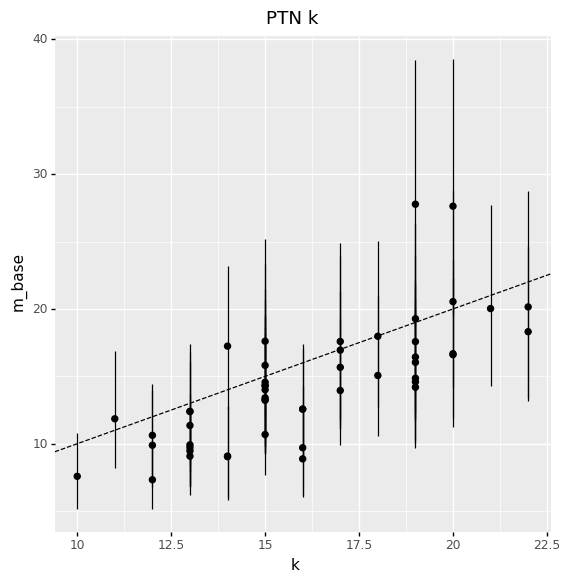

<ggplot: (-9223369102274448829)>

In [16]:
plot_param_recovery(posterior_ptn, params_ptn, "k", "k") + labs(title="PTN k ")